In [5]:
import numpy as np
import pandas as pd
import pickle
import smogn

import seaborn as sns
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split


In [6]:
df = pd.read_csv("/Users/admin/Downloads/parklane_combined_edited.csv")
print('Unfiltered row of dataframe is {}'.format(len(df)))

Unfiltered row of dataframe is 727657


### This notebook focus will be on predicting ch_sysef using various features and some selections of models

total number of rows after filter is 153962


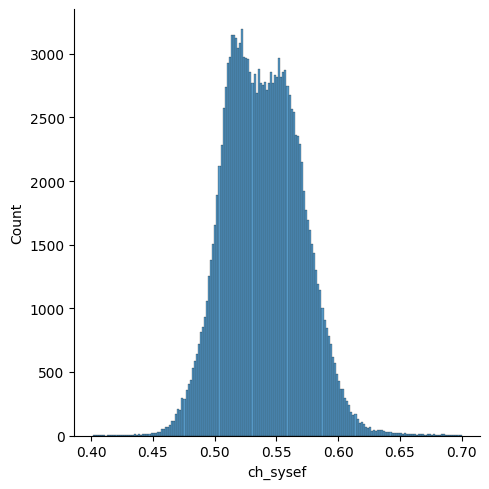

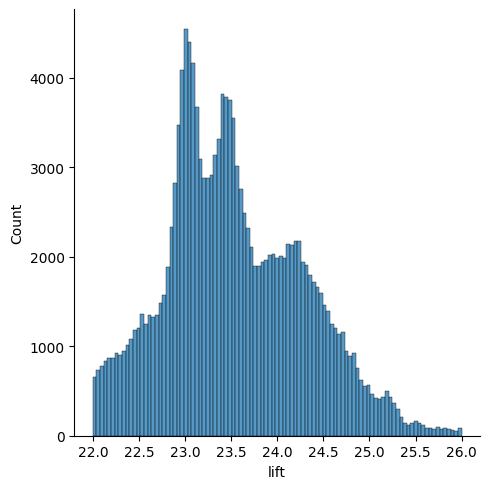

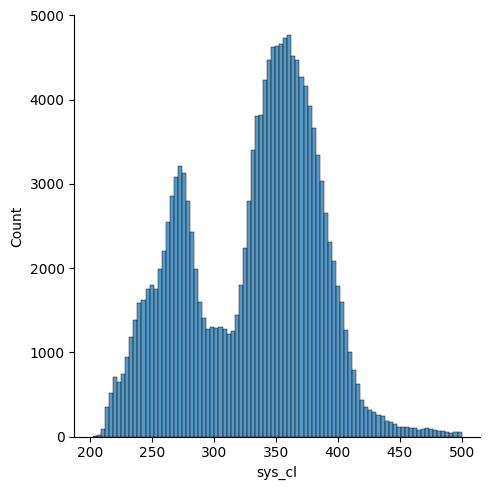

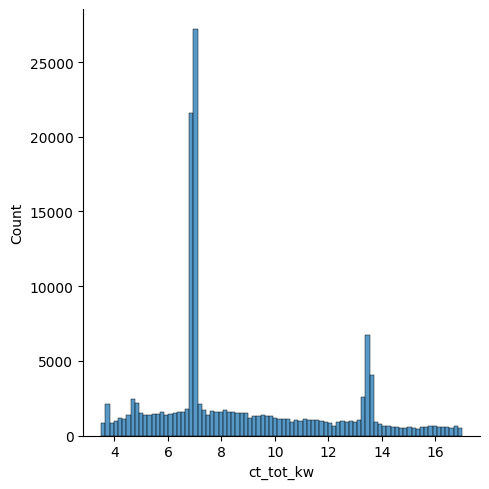

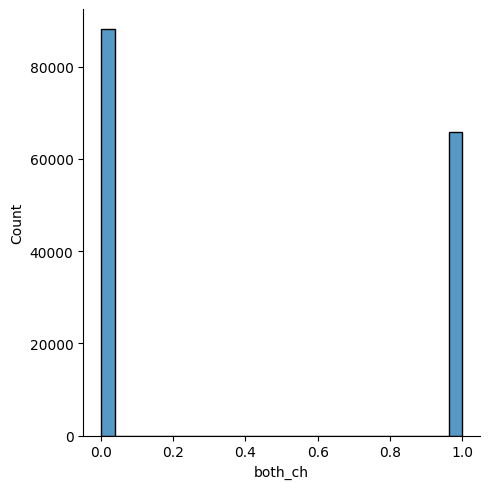

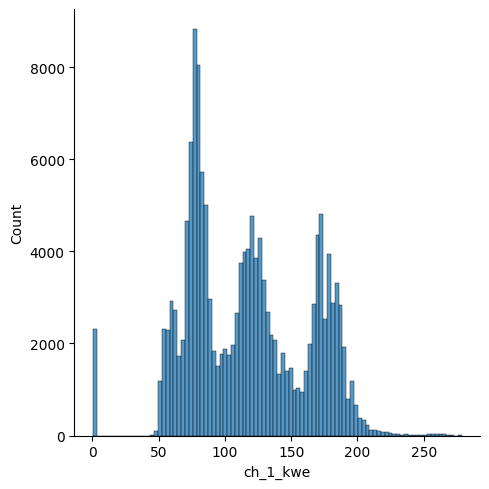

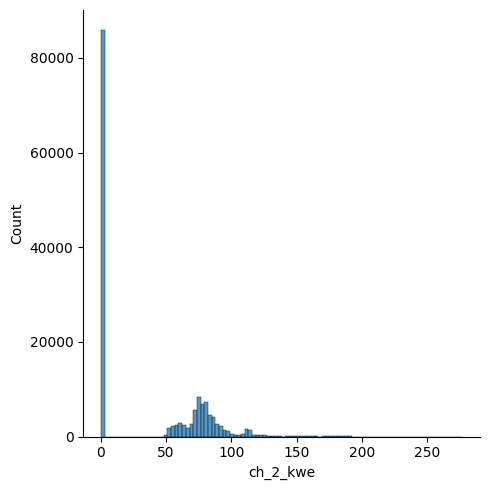

In [7]:
# filter where hr or hb is  not 0
df = df[(df['sys_hr'] != 0) | (df['sys_hb'] != 0)]
df = df[(df['h_chwst'] >=5) & (df['h_chwst'] <=20)]
df = df[(df['h_chwrt'] >=5) & (df['h_chwrt'] <=25)]
df = df[(df['pchwp_1_kw'] >=1.2) & (df['pchwp_1_kw'] <=5)]
# unsure of pchwp_2 kw filtering
#df = df[(df['pchwp_2_kw'] >=1.2) & (df['pchwp_2_kw'] <=5)]
df = df[(df['h_chwf'] >= 0) & (df['h_chwf'] <= 1500)]
df = df[(df['cwp_1_kw'] > 0) & (df['cwp_1_kw'] <=25)]
df = df[(df['cwp_2_kw'] > 0) & (df['cwp_2_kw'] <=25)]
df = df[(df['h_chwf'] >0) & (df['h_chwf'] <=1500)]
df = df[(df['h_cwst']>=20) & (df['h_cwst']<=32)]
df = df[(df['h_cwrt']>=20) & (df['h_cwrt']<=40)]
df = df[(df['ch_1_kwe']>=0) & (df['ch_1_kwe']<=350)]
df = df[(df['ch_2_kwe']>=0) & (df['ch_2_kwe']<=350)]
df = df[(df['ct_1_kw']>=0) & (df['ct_1_kw']<=15)]
df = df[(df['ct_2_kw']>=0) & (df['ct_2_kw']<=15)]
df = df[(df['sys_cl']>=200) & (df['sys_cl']<=500)]
df = df[(df['sys_hr']>0) & (df['sys_hr']<=1000)]
df = df[(df['sys_kw']>0) & (df['sys_kw']<=400)]
fil_df = df[(df['ch_sysef']>=0.4) & (df['ch_sysef']<=0.7)]

# 2 cooling tower 2 chiller pump
# cooling tower threshold 0.1
# chiller threshold 2

# replace NaN values with 0? median imputation
fil_df = fil_df.fillna(0)

# creating Lift Column, Lift: [h_cwrt-h_chwst]
fil_df['lift'] = fil_df['h_cwrt'] - fil_df['h_chwst']
fil_df['ct_tot_kw'] = fil_df['ct_1_kw'] + fil_df['ct_2_kw']
# both chillers running
fil_df['both_ch'] = (fil_df['ch_1_kwe']>=2) & (fil_df['ch_2_kwe']>=2)
fil_df['both_ch'] = fil_df['both_ch'].astype(int)

# filtering additional columns
fil_df = fil_df[(fil_df['ct_tot_kw']>=3.5) & (fil_df['ct_tot_kw']<=17)]
fil_df = fil_df[(fil_df['lift']>=22) & (fil_df['lift']<=26)]

print("total number of rows after filter is {}".format(len(fil_df)))

# selecting related features only
ch_sysef_df = fil_df[['ch_sysef', 'lift', 'sys_cl', 'ct_tot_kw', 'both_ch', 'ch_1_kwe', 'ch_2_kwe']]
# reset
ch_sysef_df = ch_sysef_df.reset_index()

# distribution
sns.displot(ch_sysef_df, x="ch_sysef")
sns.displot(ch_sysef_df, x="lift")
sns.displot(ch_sysef_df, x="sys_cl")
sns.displot(ch_sysef_df, x="ct_tot_kw")
sns.displot(ch_sysef_df, x="both_ch")
sns.displot(ch_sysef_df, x="ch_1_kwe")
sns.displot(ch_sysef_df, x="ch_2_kwe")

In [8]:
ch_sysef_df.head(5)

,index,ch_sysef,lift,sys_cl,ct_tot_kw,both_ch,ch_1_kwe,ch_2_kwe
0,653,0.594042,22.279536,376.924744,7.088,0,194.560013,0.338
1,654,0.591066,22.793373,376.842010,7.088,0,193.536026,0.336
2,655,0.586501,23.099158,377.594971,7.024,0,192.512024,0.338
3,656,0.590153,23.403518,373.803864,7.056,0,190.464020,0.336
4,657,0.538585,23.436446,364.348633,7.088,0,166.912018,0.336


## Training

In [12]:
# train_test split
X = ch_sysef_df[['lift', 'sys_cl', 'ct_tot_kw', 'both_ch', 'ch_1_kwe', 'ch_2_kwe']]
y = ch_sysef_df[['ch_sysef']]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
y.transpose()

# Training
no_of_trees = [100, 500]
min_samples_splits = [100, 500, 1000, 5000]

parameter_grid = {
    'max_depth': no_of_trees,
    'min_samples_split': min_samples_splits
}

grid_search = GridSearchCV(
    estimator= RandomForestRegressor(),
    param_grid=parameter_grid,
    cv=5
)

regr = RandomForestRegressor()
grid_search.fit(X_train, y_train)

## save model
filename = 'RF_first_both_ch.sav'
pickle.dump(grid_search, open(filename, 'wb'))

/Users/admin/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_valida

### Random Forest Regressor

In [14]:
grid_search.best_params_

{'max_depth': 100, 'min_samples_split': 100}

In [15]:
X_test.iloc[100]

lift          23.321670
sys_cl       338.774109
ct_tot_kw      5.296000
both_ch        1.000000
ch_1_kwe      77.824013
ch_2_kwe      75.776001
Name: 104096, dtype: float64

In [16]:
y_test.iloc[100]

ch_sysef    0.528272
Name: 104096, dtype: float64

In [17]:
grid_search.predict([[23.32, 338.77, 5.296, 1, 77.82, 75.77]])

/Users/admin/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


array([0.52340758])

In [ ]:
import pickle
model = pickle.load(open('/Users/admin/Desktop/optimization/parklane/RF_first_both_ch.sav', 'rb'))

model.predict([[]])

{'max_depth': 1000, 'min_samples_split': 100}

## SMOGN

In [ ]:
ch_sysef_df_smogn = smogn.smoter(
    data=ch_sysef_df,
    y='ch_sysef'
)

# distribution
sns.displot(ch_sysef_df_smogn, x="ch_sysef")
sns.displot(ch_sysef_df_smogn, x="lift")
sns.displot(ch_sysef_df_smogn, x="sys_cl")
sns.displot(ch_sysef_df_smogn, x="ct_tot_kw")
sns.displot(ch_sysef_df_smogn, x="both_ch")
sns.displot(ch_sysef_df_smogn, x="ch_1_kwe")
sns.displot(ch_sysef_df_smogn, x="ch_2_kwe")

In [ ]:
sec_df = fil_df[['ch_sysef', 'lift', 'sys_cl', 'ct_tot_kw', 'ch_1_kwe', 'ch_2_kwe', 'both_ch']]
sec_df.head(5)

,ch_sysef,lift,sys_cl,ct_tot_kw,ch_1_kwe,ch_2_kwe
timestamp,,,,,,
11/6/2023 9:18,0.640413,24.967691,456.382233,10.512000,159.744019,98.816010
11/6/2023 9:35,0.539539,22.572202,425.702484,15.968002,94.208015,98.304008
11/6/2023 9:36,0.545510,22.526289,418.937927,14.880002,94.208015,97.792015
11/6/2023 9:37,0.538678,22.601707,425.491486,13.824001,94.208015,98.816010
11/6/2023 9:38,0.543437,22.719701,422.201416,12.672002,95.232010,99.840012


In [ ]:
len(sec_df)

67277

/opt/anaconda3/envs/kaer/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/kaer/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


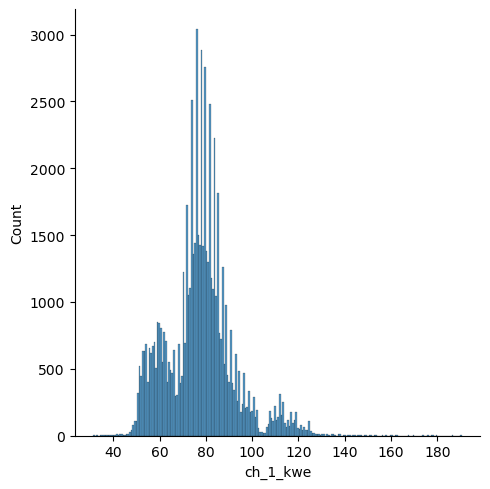

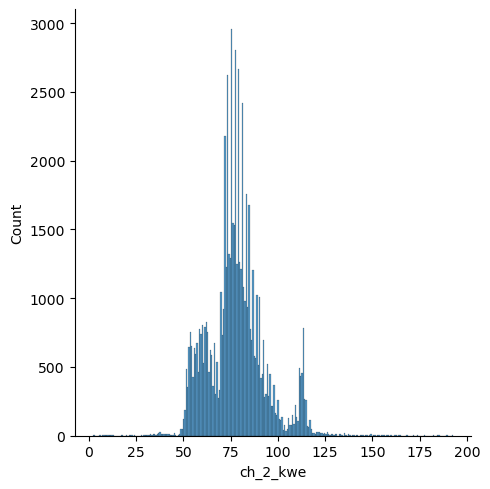

In [ ]:
sns.displot(sec_df, x="ch_1_kwe")
sns.displot(sec_df, x="ch_2_kwe")

In [ ]:
## train
X = sec_df[['lift', 'sys_cl', 'ct_tot_kw', 'ch_1_kwe', 'ch_2_kwe', 'both_ch']]
y = sec_df[['ch_sysef']]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42, test_size=0.2
)
y.transpose()

no_of_trees = [100, 500, 1000, 5000]
min_samples_splits = [100, 500, 1000, 5000] 

parameter_grid = {
    'max_depth': no_of_trees,
    'min_samples_split': min_samples_splits
}

sec_model = GridSearchCV(
    estimator= RandomForestRegressor(),
    param_grid=parameter_grid,
    cv=5
)

sec_model.fit(X_train, y_train)

/opt/anaconda3/envs/kaer/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/kaer/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/kaer/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/kaer/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:686:

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [100, 500, 1000],
                         'min_samples_split': [100, 500, 1000]})

In [ ]:
## save
filename = 'RF_second_both_ch.sav'
pickle.dump(sec_model, open(filename, 'wb'))